In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import nibabel as nib
from neuron.plot import slices
import numpy as np
import scipy.io as sio
sys.path.append('../ext/medipy-lib')
from medipy.metrics import dice
import datagenerators
from neuron.plot import slices
from pynd.segutils import seg_overlay, seg_overlap
import matplotlib.pyplot as plt
import tensorflow as tf
from restrict import restrict_GPU_tf, restrict_GPU_keras
from keras.backend.tensorflow_backend import set_session
from visualize import visualize_seg_contour, visualize_seg

Using TensorFlow backend.


In [3]:
atlas_n_filename = '../t2_atlas_n_027_S_2219.nii'
atlas_vol = nib.load(atlas_n_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

In [30]:
# d = 3
# patch_size = 3
var=0.004
vol_size = (160, 192, 224)  
def ssd_shift(image, direction, patch_size):
    # expects a 3d image
    x,y,z = vol_size
    new_shift = np.clip(direction, 0, None)
    old_shift = -np.clip(direction, None, 0)

    # translate images
    new_image = image[new_shift[0]:x-old_shift[0], new_shift[1]:y-old_shift[1], new_shift[2]:z-old_shift[2]]
    old_image = image[old_shift[0]:x-new_shift[0], old_shift[1]:y-new_shift[1], old_shift[2]:z-new_shift[2]]
    # get squared difference
    diff = tf.square(new_image - old_image)

    # pad the diff
    padding = np.transpose([old_shift, new_shift])
    diff = tf.pad(diff, padding)

    # apply convolution
    sum_filt = tf.ones([patch_size, patch_size, patch_size, 1, 1])/(patch_size**3)
    conv = tf.nn.conv3d(diff[tf.newaxis,:,:,:,tf.newaxis], sum_filt, [1]*5, 'SAME')
    return conv

def loss(y_true, y_pred, d, patch_size):
    ndims = 3
    y_true = tf.squeeze(y_true)
    y_pred = tf.squeeze(y_pred)
    loss_tensor = 0
    for i in range(1):
        direction = [0]*3
        direction[i] = d

        loss_tensor += tf.reduce_mean(tf.abs(ssd_shift(y_true, direction, patch_size) - ssd_shift(y_pred, direction, patch_size)))

        direction[i] = -d
        loss_tensor += tf.reduce_mean(tf.abs(ssd_shift(y_true, direction, patch_size) - ssd_shift(y_pred, direction, patch_size)))

    return tf.reduce_mean(loss_tensor)



Using GPU:3 with 0% of the memory
Using GPU:3 with 0% of the memory


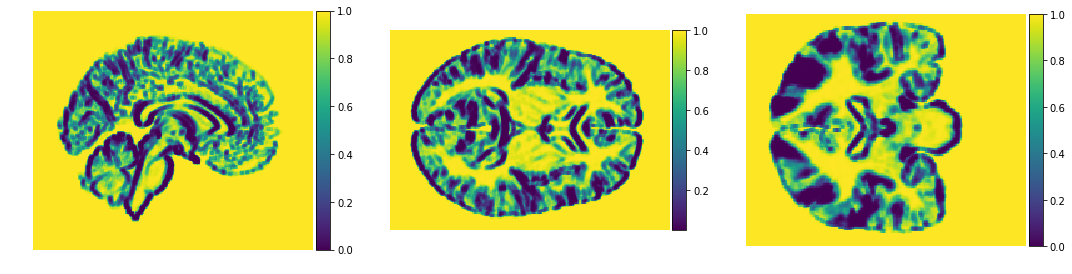

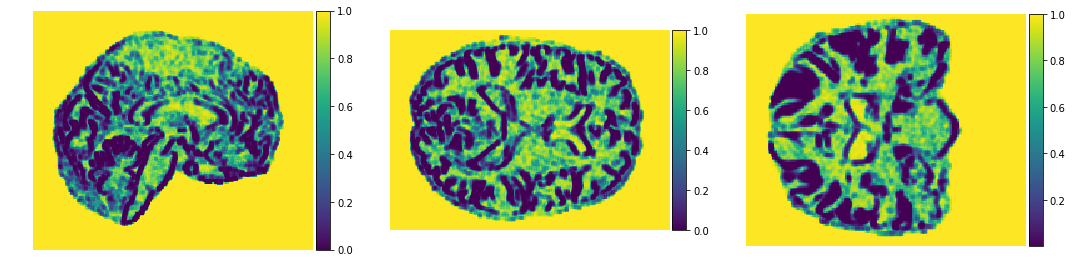

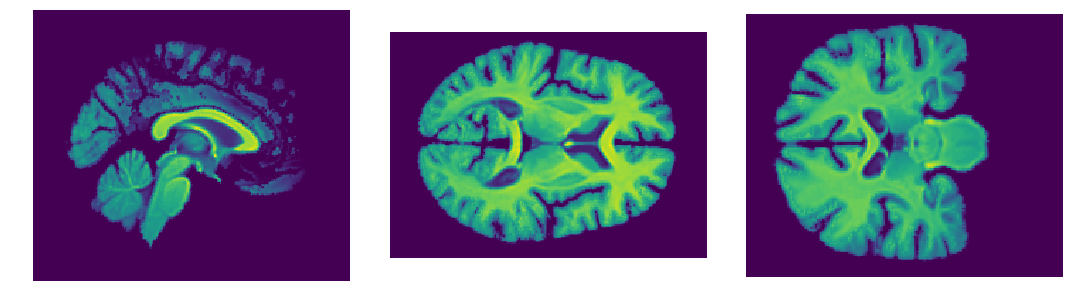

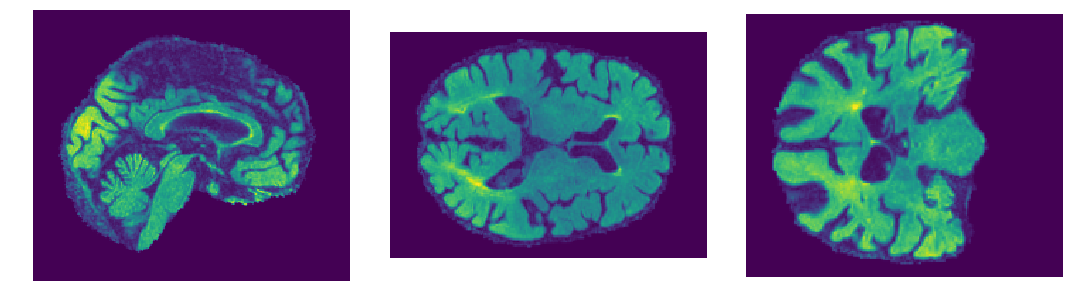

In [29]:
d = 2
patch_size = 3

gpu_id = 3
gpu = '/gpu:' + str(gpu_id)
#     print(gpu)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

restrict_GPU_tf(str(gpu_id))
restrict_GPU_keras(str(gpu_id))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))
sess = tf.Session(config=config)

with tf.device(gpu):
    with sess.as_default():
        a = np.squeeze(ssd_shift(t1_atlas, np.array([0, 0, d]), patch_size).eval())
        b = np.squeeze(ssd_shift(atlas_vol, np.array([0, 0, d]), patch_size).eval())
#         print(np.squeeze(a))
        slices([a[80,:,:], a[:, 90, :], a[:, :, 100]], do_colorbars=True, cmaps=['viridis', 'viridis', 'viridis'])
        slices([b[80,:,:], b[:, 90, :], b[:, :, 100]], do_colorbars=True, cmaps=['viridis', 'viridis', 'viridis'])
        slices([t1_atlas[80,:,:], t1_atlas[:, 90, :], t1_atlas[:, :, 100]], do_colorbars=True)
        slices([atlas_vol[80,:,:], atlas_vol[:, 90, :], atlas_vol[:, :, 100]], do_colorbars=True)

In [21]:
original = nib.load("../t1_atlas.nii").get_data()
original_seg = nib.load("../t1_atlas_seg.nii").get_data()
atlas = nib.load("../t2_atlas_n_027_S_2219.nii").get_data()
atlas_seg = nib.load("../data/t2_atlas_seg_027_S_2219.nii").get_data()
ants_warped = nib.load("../test_ants_t1tot2.nii.gz").get_data()
nifty_warped = nib.load("../test_niftyreg_t1tot2.nii").get_data()
nifty_seg = nib.load('../test_niftyreg_t1tot2_seg.nii').get_data()
ants_seg = nib.load('../test_ants_t1tot2_seg.nii').get_data()
vm_warped = nib.load("../test_voxelmorph_t1tot2.nii").get_data()
vm_seg = nib.load('../test_voxelmorph_t1tot2_seg.nii').get_data()
mind_warped = nib.load("../test_mind.nii").get_data()
mind_seg = nib.load('../test_mind_seg.nii').get_data()

In [24]:
d = 2
patch_size = 3

with tf.device(gpu):
    with sess.as_default():
        l = loss(atlas_vol, vm_warped, d, patch_size).eval()
        print('vm', l)
        l = loss(atlas_vol, ants_warped.astype('float32'), d, patch_size).eval()
        print('ants', l)
        l = loss(atlas_vol, nifty_warped, d, patch_size).eval()
        print('nifty', l)
        l = loss(atlas_vol, t1_atlas, d, patch_size).eval()
        print('t1 atlas', l)

vm 0.21216872
ants 0.20437554
nifty 0.20867649
t1 atlas 0.23324749


(array([ 323133,  118989,  105986,  106341,  115195,  134296,  165594,
        217167,  314610, 5279969]), array([1.76810647e-13, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
       4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
       8.00000000e-01, 9.00000000e-01, 1.00000000e+00]))
0.8735955
0.26702803
(array([ 323133,  118989,  105986,  106341,  115195,  134296,  165594,
        217167,  314610, 5279969]), array([1.76810647e-13, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
       4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
       8.00000000e-01, 9.00000000e-01, 1.00000000e+00]))
0.8735959
0.26702803
(array([ 324538,  128477,  114159,  114938,  124401,  142323,  172687,
        224018,  316309, 5219430]), array([4.38249992e-11, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
       4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
       8.00000000e-01, 9.00000000e-01, 1.00000000e+00]))
0.8687932
0.27039993
(array([ 378741,  1

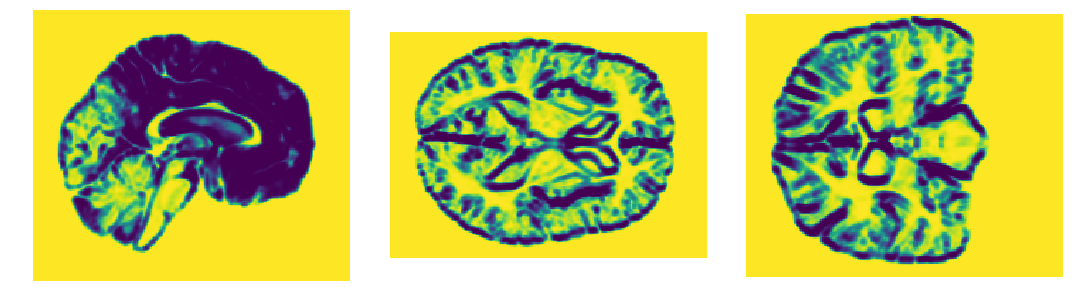

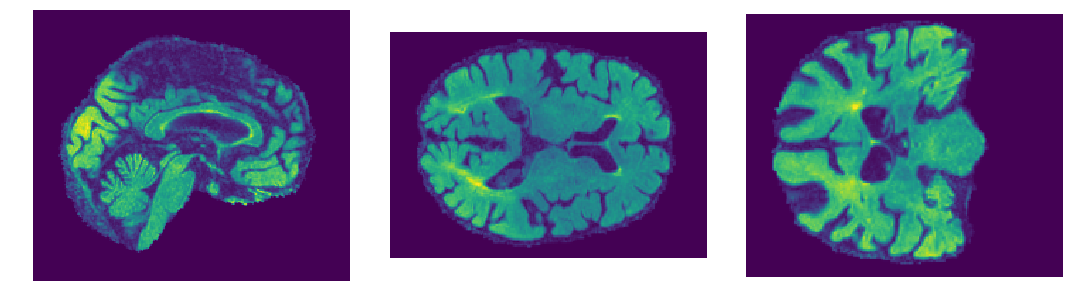

0.20437554


In [25]:
with tf.device(gpu):
    with sess.as_default():
        a = np.squeeze(ssd_shift(ants_warped.astype('float32'), np.array([0, 0, d]), 3).eval())
        print(np.histogram(a))
        print(np.mean(a[np.nonzero(a)]))
        print(np.std(a[np.nonzero(a)]))

        a = np.squeeze(ssd_shift(ants_warped.astype('float32'), np.array([0, 0, -d]), 3).eval())
        print(np.histogram(a))
        print(np.mean(a[np.nonzero(a)]))
        print(np.std(a[np.nonzero(a)]))
        
        a = np.squeeze(ssd_shift(ants_warped.astype('float32'), np.array([0, d, 0]), 3).eval())
        print(np.histogram(a))
        print(np.mean(a[np.nonzero(a)]))
        print(np.std(a[np.nonzero(a)]))
        
        a = np.squeeze(ssd_shift(ants_warped.astype('float32'), np.array([d, 0, 0]), 3).eval())
        print(np.histogram(a))
        print(np.mean(a[np.nonzero(a)]))
        print(np.std(a[np.nonzero(a)]))
        
        slices([a[80,:,:], a[:, 90, :], a[:, :, 100]])
        slices([atlas_vol[80,:,:], atlas_vol[:, 90, :], atlas_vol[:, :, 100]])
        l = loss(atlas_vol, ants_warped.astype('float32'), 2, 3).eval()
        print(l)

(array([6631377,  168774,   58104,   17323,    4385,    1068,     225,
            14,       9,       1]), array([0.        , 0.01174548, 0.02349096, 0.03523644, 0.04698192,
       0.0587274 , 0.07047288, 0.08221836, 0.09396384, 0.10570932,
       0.1174548 ]))
0.004118669
0.0072567677
(array([6631377,  168774,   58104,   17323,    4385,    1068,     225,
            14,       9,       1]), array([0.        , 0.01174548, 0.02349096, 0.03523644, 0.04698192,
       0.0587274 , 0.07047288, 0.08221836, 0.09396384, 0.10570932,
       0.1174548 ]))
0.004118669
0.0072567677
(array([6568579,  201027,   72756,   25605,    7947,    3117,    1707,
           447,      73,      22]), array([0.        , 0.00954033, 0.01908065, 0.02862098, 0.03816131,
       0.04770163, 0.05724196, 0.06678229, 0.07632262, 0.08586294,
       0.09540327]))
0.0041093957
0.006958048
(array([6543806,  211399,   76029,   33574,   12658,    3161,     550,
            77,      15,      11]), array([0.        , 0.01036723, 0

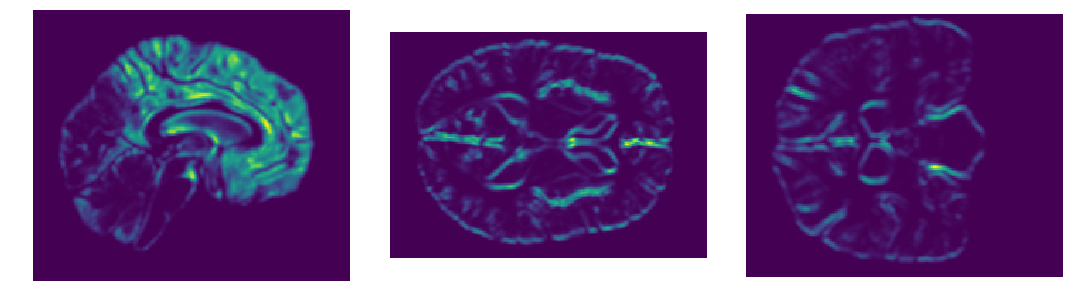

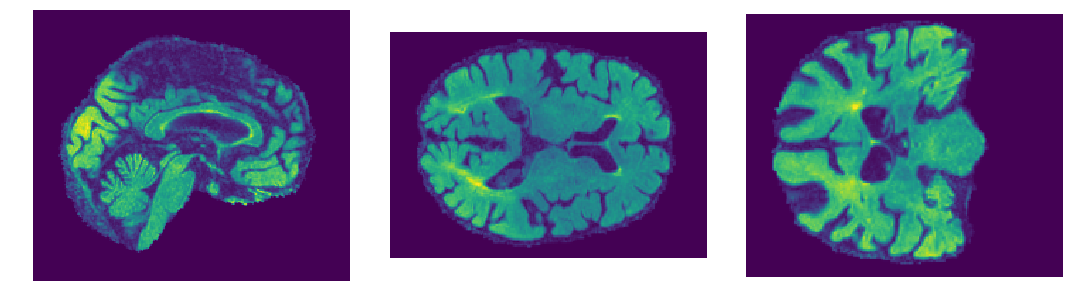

0.0059006033


In [31]:
with tf.device(gpu):
    with sess.as_default():
        a = np.squeeze(ssd_shift(ants_warped.astype('float32'), np.array([0, 0, d]), 3).eval())
        print(np.histogram(a))
        print(np.mean(a[np.nonzero(a)]))
        print(np.std(a[np.nonzero(a)]))

        a = np.squeeze(ssd_shift(ants_warped.astype('float32'), np.array([0, 0, -d]), 3).eval())
        print(np.histogram(a))
        print(np.mean(a[np.nonzero(a)]))
        print(np.std(a[np.nonzero(a)]))
        
        a = np.squeeze(ssd_shift(ants_warped.astype('float32'), np.array([0, d, 0]), 3).eval())
        print(np.histogram(a))
        print(np.mean(a[np.nonzero(a)]))
        print(np.std(a[np.nonzero(a)]))
        
        a = np.squeeze(ssd_shift(ants_warped.astype('float32'), np.array([d, 0, 0]), 3).eval())
        print(np.histogram(a))
        print(np.mean(a[np.nonzero(a)]))
        print(np.std(a[np.nonzero(a)]))
        
        slices([a[80,:,:], a[:, 90, :], a[:, :, 100]])
        slices([atlas_vol[80,:,:], atlas_vol[:, 90, :], atlas_vol[:, :, 100]])
        l = loss(atlas_vol, ants_warped.astype('float32'), 2, 3).eval()
        print(l)

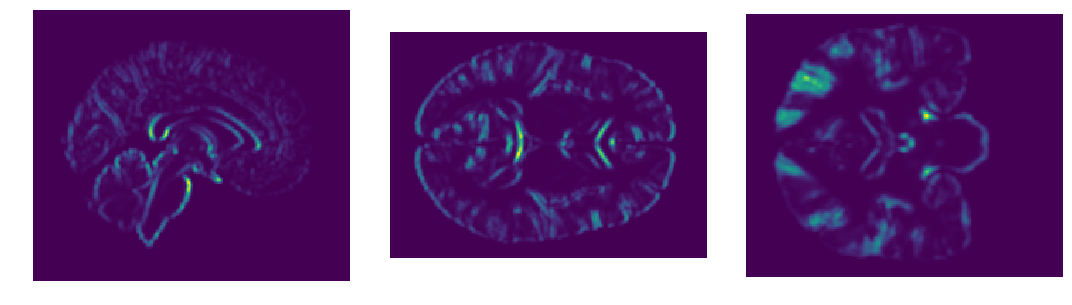

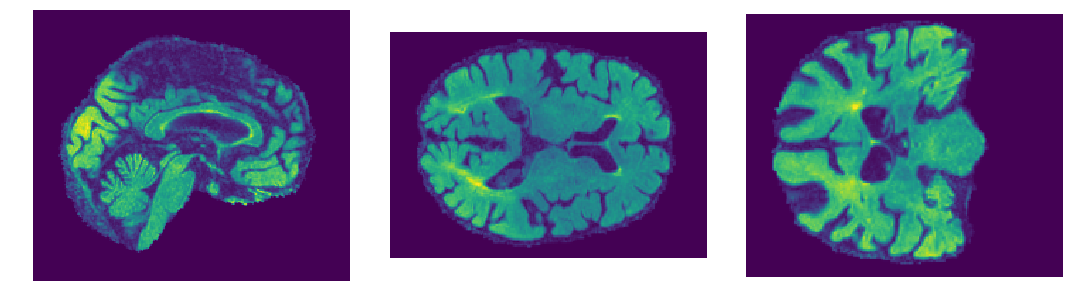

0.17665134


In [19]:
with tf.device(gpu):
    with sess.as_default():
        a = np.squeeze(ssd_shift(t1_atlas, np.array([0, 0, d])).eval())
#         print(np.squeeze(a))
        slices([a[80,:,:], a[:, 90, :], a[:, :, 100]])
        slices([atlas_vol[80,:,:], atlas_vol[:, 90, :], atlas_vol[:, :, 100]])
        l = loss(atlas_vol, t1_atlas).eval()
        print(l)

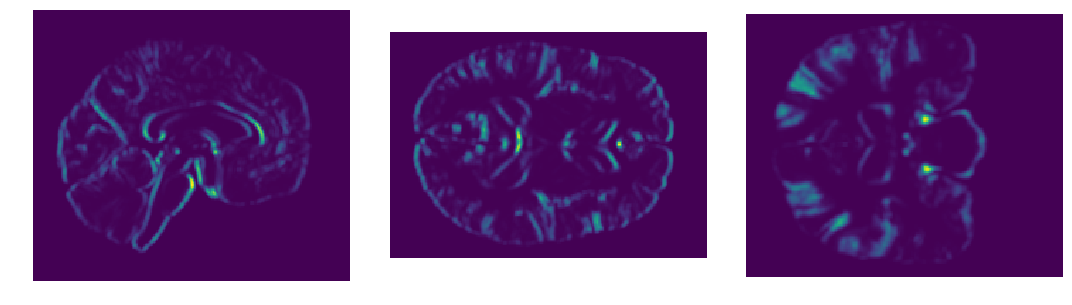

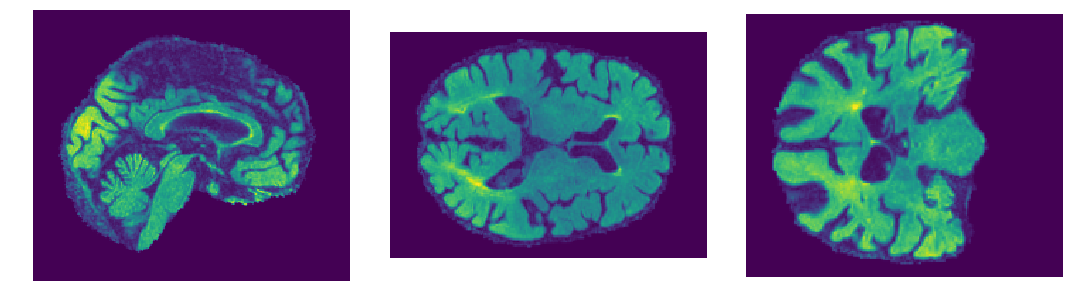

0.1680861


In [20]:
with tf.device(gpu):
    with sess.as_default():
        a = np.squeeze(ssd_shift(nifty_warped, np.array([0, 0, d])).eval())
#         print(np.squeeze(a))
        slices([a[80,:,:], a[:, 90, :], a[:, :, 100]])
        slices([atlas_vol[80,:,:], atlas_vol[:, 90, :], atlas_vol[:, :, 100]])
        l = loss(atlas_vol, nifty_warped).eval()
        print(l)

In [15]:
good_labels = sio.loadmat('../data/labels.mat')['labels'][0]
idx_map = {}
for i in range(len(good_labels)):
    idx_map[good_labels[i]] = i

regions = ['Brain-Stem', 'Thalamus', 'Cerebellum-Cortex', 'Cerebral-W.Matter', 'Cerebellum-W.Matter', 'Putamen', 'VentralDC', 'Palladium', 'Caudate', 'Lateral-Ventricle', 'Hippocampus', '3rd-Ventricle', '4th-Ventricle', 'Amygdala', 'Cerebral-Cortex', 'CSF', 'choroid-plexus']
reg_to_num_list = {'Brain-Stem': [16],
                   'Thalamus': [10, 46],
                   'Cerebellum-Cortex': [8, 47],
                   'Cerebral-W.Matter': [2, 41],
                   'Cerebellum-W.Matter': [7, 46],
                   'Putamen': [12, 51],
                   'VentralDC': [28, 60],
                   'Palladium': [13, 52],
                   'Caudate': [11, 50],
                   'Lateral-Ventricle': [4, 43],
                   'Hippocampus': [17, 53],
                   '3rd-Ventricle': [14],
                   '4th-Ventricle': [15],
                   'Amygdala': [18, 54],
                   'Cerebral-Cortex': [3, 42],
                   'CSF': [24],
                   'choroid-plexus': [31, 63]}


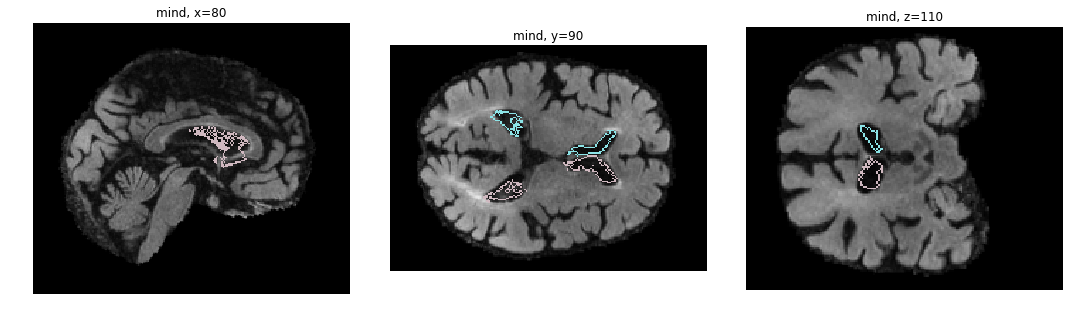

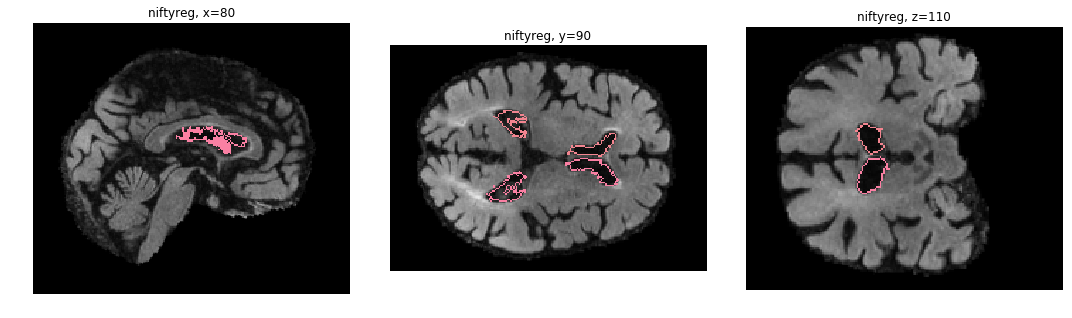

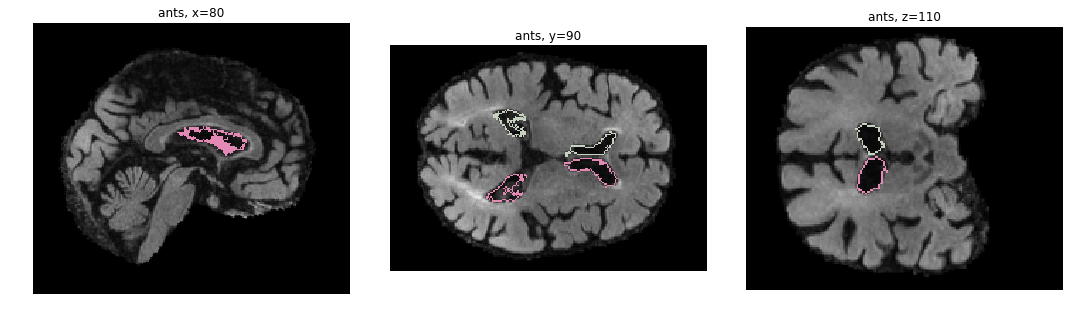

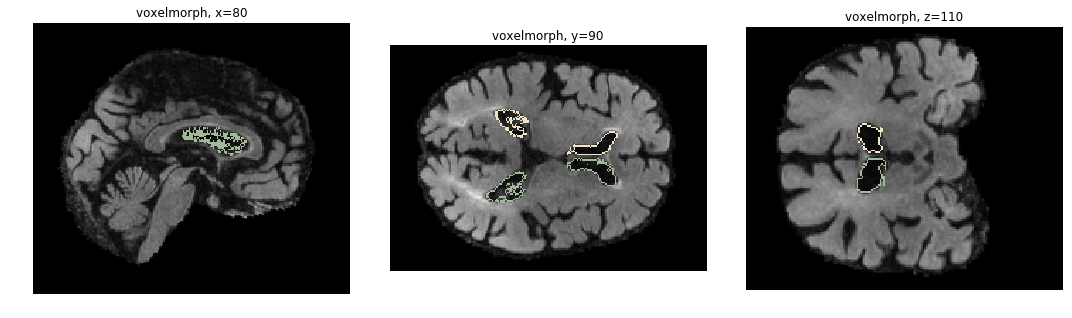

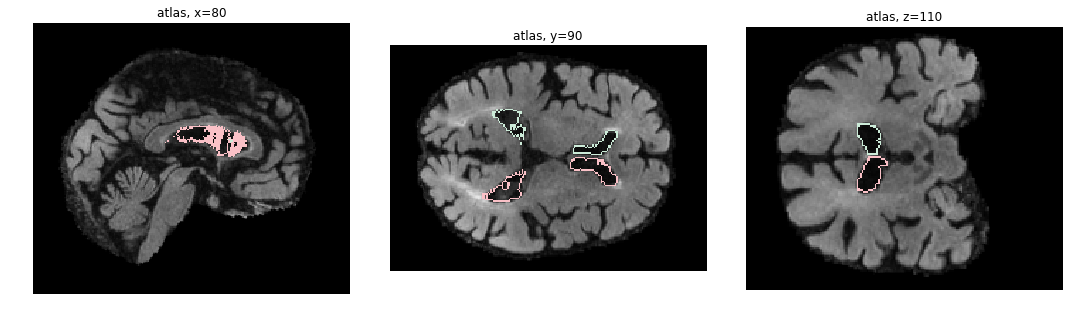

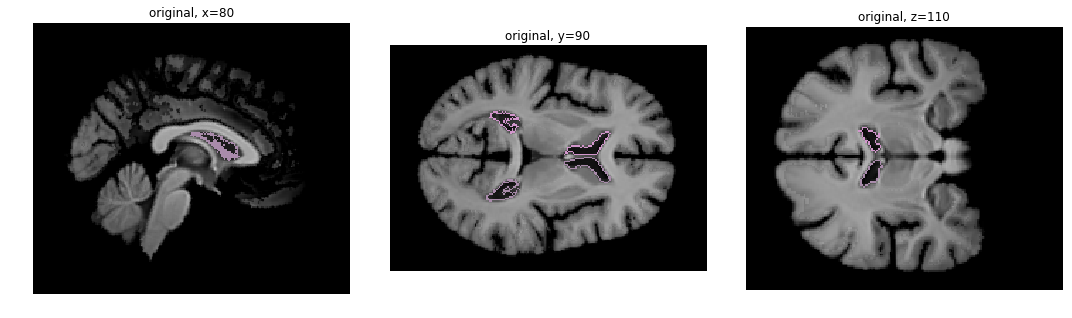

In [20]:
visualize_seg_contour(atlas, mind_seg, title='mind', region_numbers=reg_to_num_list['Lateral-Ventricle'])
visualize_seg_contour(atlas, nifty_seg, title='niftyreg', region_numbers=reg_to_num_list['Lateral-Ventricle'])
visualize_seg_contour(atlas, ants_seg, title='ants', region_numbers=reg_to_num_list['Lateral-Ventricle'])
visualize_seg_contour(atlas, vm_seg, title='voxelmorph', region_numbers=reg_to_num_list['Lateral-Ventricle'])

visualize_seg_contour(atlas, atlas_seg, title='atlas', region_numbers=reg_to_num_list['Lateral-Ventricle'])
visualize_seg_contour(original, original_seg, title='original', region_numbers=reg_to_num_list['Lateral-Ventricle'])

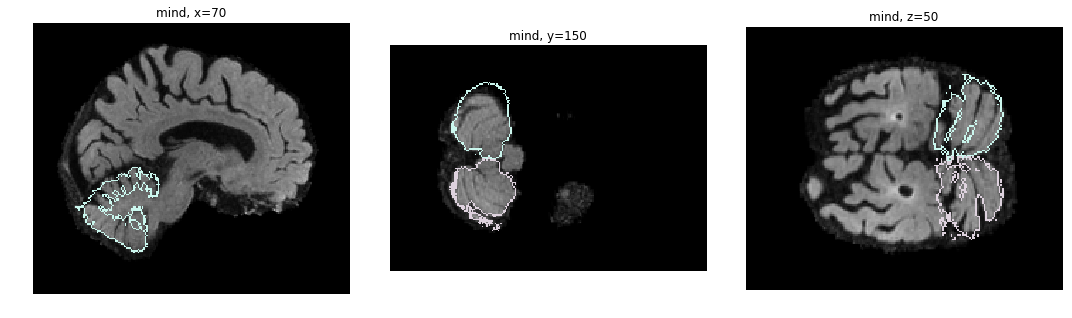

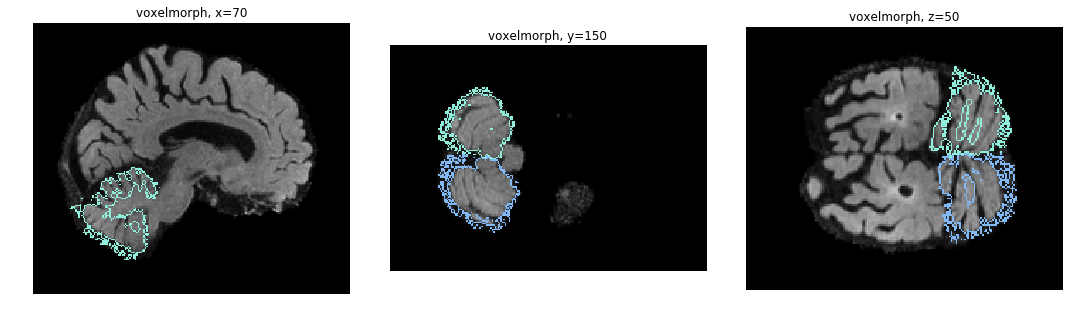

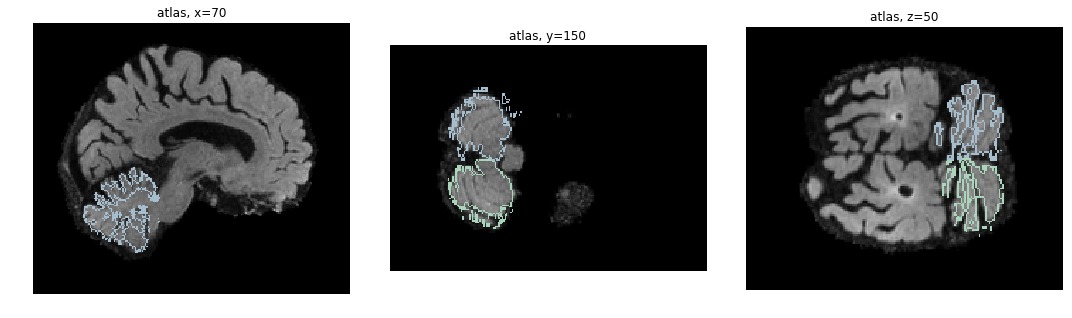

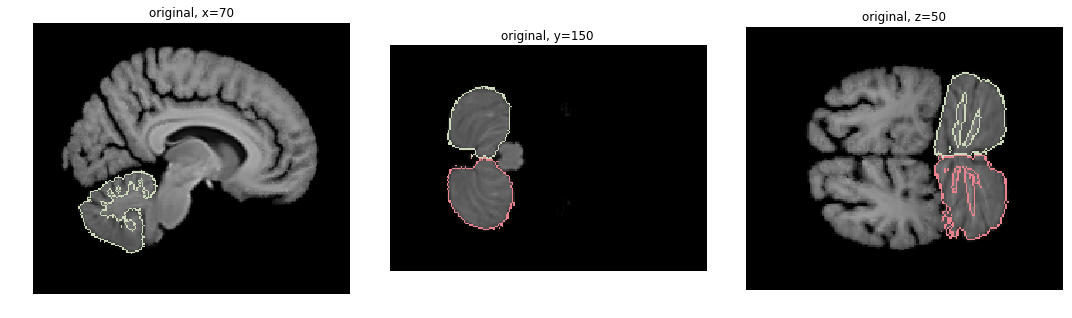

In [28]:
visualize_seg_contour(atlas, mind_seg, title='mind', region_numbers=reg_to_num_list['Cerebellum-Cortex'], slice_idx=[70, 150, 50])
# visualize_seg_contour(atlas, nifty_seg, title='niftyreg', region_numbers=reg_to_num_list['Cerebellum-Cortex'], slice_idx=[70, 150, 50])
# visualize_seg_contour(atlas, ants_seg, title='ants', region_numbers=reg_to_num_list['Cerebellum-Cortex'], slice_idx=[70, 150, 50])
visualize_seg_contour(atlas, vm_seg, title='voxelmorph', region_numbers=reg_to_num_list['Cerebellum-Cortex'], slice_idx=[70, 150, 50])

visualize_seg_contour(atlas, atlas_seg, title='atlas', region_numbers=reg_to_num_list['Cerebellum-Cortex'], slice_idx=[70, 150, 50])
visualize_seg_contour(original, original_seg, title='original', region_numbers=reg_to_num_list['Cerebellum-Cortex'], slice_idx=[70, 150, 50])

nifty dice 0.6242017828838189
ants dice 0.6402834106439894
vm dice 0.6942060355272022
mind dice 0.6200145769923221


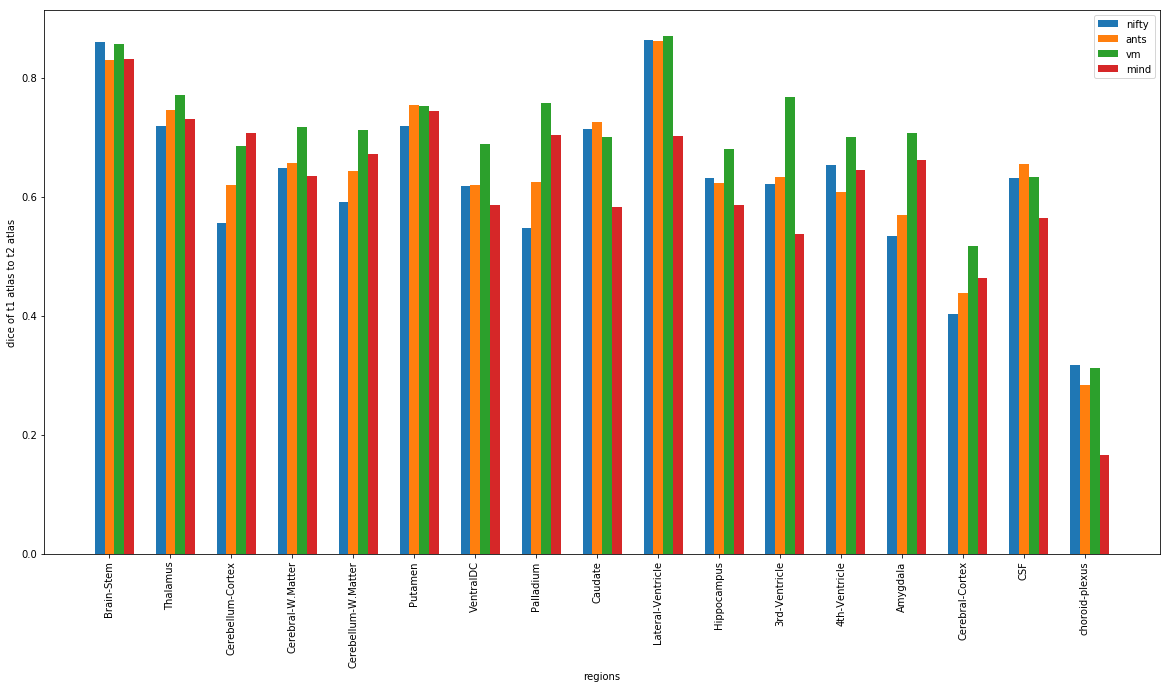

In [17]:
plt.figure(figsize=(20,10))
nifty_dice, _ = dice(atlas_seg, nifty_seg, labels=good_labels, nargout=2)
ants_dice, _ = dice(atlas_seg, ants_seg, labels=good_labels, nargout=2)
vm_dice, _ = dice(atlas_seg, vm_seg, labels=good_labels, nargout=2)
mind_dice, _ = dice(atlas_seg, mind_seg, labels=good_labels, nargout=2)

print('nifty dice', np.mean(nifty_dice))
print('ants dice', np.mean(ants_dice))
print('vm dice', np.mean(vm_dice))
print('mind dice', np.mean(mind_dice))

inds = np.arange(len(regions))
nifty_dice_ordered = []
ants_dice_ordered = []
vm_dice_ordered = []
mind_dice_ordered = []

for region in regions:
    nifty_sum = 0
    ants_sum = 0
    vm_sum = 0
    mind_sum = 0
    for num in reg_to_num_list[region]:
        nifty_sum += nifty_dice[idx_map[num]]
        ants_sum += ants_dice[idx_map[num]]
        vm_sum += vm_dice[idx_map[num]]
        mind_sum += mind_dice[idx_map[num]]

    nifty_dice_ordered.append(nifty_sum/len(reg_to_num_list[region]))
    ants_dice_ordered.append(ants_sum/len(reg_to_num_list[region]))
    vm_dice_ordered.append(vm_sum/len(reg_to_num_list[region]))
    mind_dice_ordered.append(mind_sum/len(reg_to_num_list[region]))

plt.bar(inds, nifty_dice_ordered, 0.16, label='nifty')
plt.bar(inds+0.16, ants_dice_ordered, 0.16, label='ants')
plt.bar(inds+0.32, vm_dice_ordered, 0.16, label='vm')
plt.bar(inds+0.48, mind_dice_ordered, 0.16, label='mind')

plt.legend()
plt.ylabel('dice of t1 atlas to t2 atlas')
plt.xlabel('regions')
plt.xticks(inds+0.16, regions, rotation='vertical')
plt.show()